<a href="https://colab.research.google.com/github/np03cs4a240078-wq/CONCEPT_OF_AI_ASSESSMENTS/blob/main/2463002_Kapil_Adhikari_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Classification Task (RTA Dataset)

## Goal
The objective is to build a machine learning model to predict **`Accident_severity`** based on various factors like road conditions, light conditions, and vehicle details.

### Models Used:
1.  **Neural Network (MLPClassifier)** (Compulsory)
2.  **Logistic Regression**
3.  **Random Forest Classifier**

### Approach:
1.  **Data Inspection & Cleaning** (Show -> Reason -> Act)
2.  **Exploratory Data Analysis (EDA)**
3.  **Preprocessing**
4.  **Modeling & Tuning**
5.  **Comparison & Evaluation**

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SelectFromModel

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Handling Imbalance
from imblearn.over_sampling import SMOTE

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Inspect Data

In [30]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/AI/RTA Dataset.csv')

# Show first 5 rows
df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


## 3. Data Cleaning: The "Show -> Reason -> Act" Process
We need to identify potential issues (missing values, wrong types) before fixing them.

In [31]:
# STEP 1: SHOW the Data Structure
print("--- Data Info (Types) ---")
print(df.info())

print("\n--- Missing Values Count ---")
print(df.isnull().sum())

--- Data Info (Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_

### 3.1 Statistical Reasoning for Imputation

**Observation**:
- Features like `Defect_of_vehicle` (4427 missing), `Service_year_of_vehicle` (3928 missing), and others have substantial missing data.
- Crucially, the `.info()` output shows these columns are **Dtype: object** (Categorical/String).

**Reasoning**:
- **Mean/Median Imputation**: Impossible. You cannot calculate the "average" of text categories like "No defect" or "One year".
- **Dropping Rows**: Would result in losing >30% of the dataset, reducing statistical power.
- **Mode Imputation**: Filling with the **Most Frequent Value** is the standard statistical approach for categorical data as it preserves the most likely category probability.

**Action**: We will apply **Mode Imputation** to all missing categorical columns.

In [32]:
# STEP 3: ACT (Apply Cleaning)

# Columns with missing values identified from step 1
missing_cols = [
    'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
    'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
    'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
    'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
    'Type_of_collision', 'Vehicle_movement', 'Work_of_casuality', 'Fitness_of_casuality'
]

# Imputing with Mode
for col in missing_cols:
    most_frequent_value = df[col].mode()[0]
    df[col].fillna(most_frequent_value, inplace=True)

# Verifying the action worked
print("Missing Values After Imputation:", df.isnull().sum().sum())

Missing Values After Imputation: 0


### 3.2 Reasoning for Feature Dropping (`Time`)
**Observation**: The `Time` column contains exact timestamps like '17:02:00'.
**Reasoning**:
1. High Cardinality: Almost every row has a unique time, making it noise for a classifier without aggregating (e.g., into 'Morning', 'Afternoon').
2. Redundancy: We already have `Light_conditions` (Daylight, Darkness), which captures the most critical aspect of time regarding road safety.
**Action**: Drop the `Time` column to reduce dimensionality and noise.

In [33]:
# ACT: Drop Time
df.drop(columns=['Time'], inplace=True)
print("Time column dropped.")

Time column dropped.


## 4. Exploratory Data Analysis (EDA): Statistical Proof
We visualize the data to justify our preprocessing decisions (like handling imbalance).

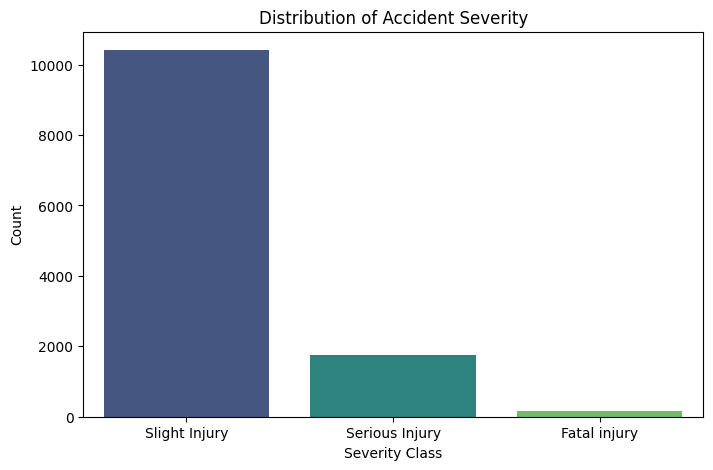

Accident_severity
Slight Injury     0.845648
Serious Injury    0.141523
Fatal injury      0.012829
Name: proportion, dtype: float64


In [34]:
# SHOW: Target Variable Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Accident_severity', data=df, palette='viridis')
plt.title('Distribution of Accident Severity')
plt.xlabel('Severity Class')
plt.ylabel('Count')
plt.show()

print(df['Accident_severity'].value_counts(normalize=True))

In [35]:
import pandas as pd
import numpy as np

# Select numeric columns for EDA
numeric_cols = df.select_dtypes(include=np.number).columns

# Create a list to store EDA statistics dictionaries
eda_data = []

for col in numeric_cols:
    mean_val = df[col].mean()
    mode_val = df[col].mode()[0]  # take first mode if multiple
    q1 = df[col].quantile(0.25)
    q2 = df[col].quantile(0.50)
    q3 = df[col].quantile(0.75)
    sd_val = df[col].std()

    eda_data.append({
        'Feature': col,
        'Mean': mean_val,
        'Mode': mode_val,
        'Q1': q1,
        'Q2': q2,
        'Q3': q3,
        'SD': sd_val
    })

# Create the DataFrame from the list of dictionaries after the loop
eda_stats = pd.DataFrame(eda_data)

# Display EDA statistics
print(eda_stats)

                       Feature      Mean  Mode   Q1   Q2   Q3        SD
0  Number_of_vehicles_involved  2.040679     2  2.0  2.0  2.0  0.688790
1         Number_of_casualties  1.548149     1  1.0  1.0  2.0  1.007179


### 4.1 Statistical Decision on Imbalance
**Observation**:
- 'Slight Injury' accounts for ~85% of the data.
- 'Fatal Injury' accounts for <2%.

**Reasoning**:
- A standard model trained on this would achieve 85% accuracy simply by guessing 'Slight Injury' every time (Zero Rule Baseline).
- To detect 'Fatal' accidents (which are the most important), we **must** rebalance the dataset.

**Action**: We will use **SMOTE** (Synthetic Minority Over-sampling Technique) in the preprocessing step to synthetically generate examples for the minority classes.

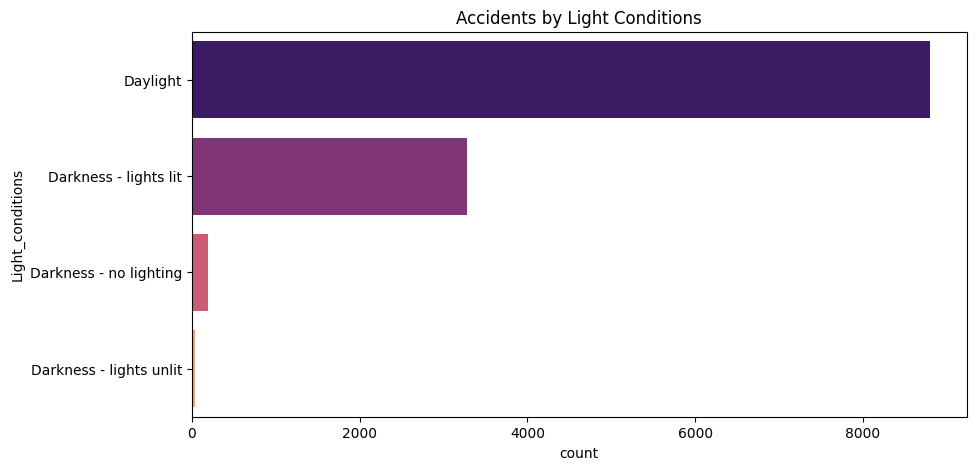

In [36]:
# SHOW: Accidents by Light Conditions
plt.figure(figsize=(10, 5))
sns.countplot(y='Light_conditions', data=df, palette='magma')
plt.title('Accidents by Light Conditions')
plt.show()

**Reasoning**: The plot confirms substantial variance (Daylight vs Darkness). This variance is useful signal for the model, justifying our decision to **keep** this feature.

## 5. Feature Engineering & Preprocessing

In [37]:
# 5.1 Encoding
le = LabelEncoder()
df['Accident_severity'] = le.fit_transform(df['Accident_severity'])
print("Target Classes Encoded:", le.classes_)

X = df.drop(columns=['Accident_severity'])
y = df['Accident_severity']
X = pd.get_dummies(X, drop_first=True)
print("One-Hot Encoding Applied. New Shape:", X.shape)

Target Classes Encoded: ['Fatal injury' 'Serious Injury' 'Slight Injury']
One-Hot Encoding Applied. New Shape: (12316, 178)


In [38]:
# 5.2 Splitting & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data Split and Scaled.")

Data Split and Scaled.


In [39]:
# 5.3 ACT: Applying SMOTE (Based on EDA decision)
print("Before SMOTE:", pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", pd.Series(y_resampled).value_counts())
print("Classes successfully balanced.")

Before SMOTE: Accident_severity
2    8331
1    1394
0     127
Name: count, dtype: int64
After SMOTE: Accident_severity
2    8331
1    8331
0    8331
Name: count, dtype: int64
Classes successfully balanced.


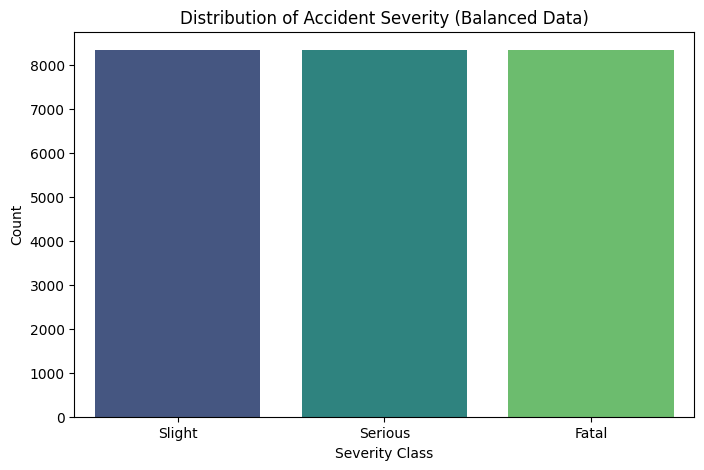

Accident_severity
Slight     0.333333
Serious    0.333333
Fatal      0.333333
Name: proportion, dtype: float64


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert y_resampled to a DataFrame for plotting
y_balanced_df = pd.DataFrame({'Accident_severity': y_resampled})

# Map numeric classes to descriptive labels
class_labels = {0: 'Fatal', 1: 'Serious', 2: 'Slight'}
y_balanced_df['Accident_severity'] = y_balanced_df['Accident_severity'].map(class_labels)

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Accident_severity', data=y_balanced_df, palette='viridis')
plt.title('Distribution of Accident Severity (Balanced Data)')
plt.xlabel('Severity Class')
plt.ylabel('Count')
plt.show()

# Print normalized value counts
print(y_balanced_df['Accident_severity'].value_counts(normalize=True))


## 6. Phase 1: Training Default Models (No Tuning)

In [41]:
model_results = []

# Logistic Regression
lr_default = LogisticRegression(max_iter=1000, random_state=42)
lr_default.fit(X_resampled, y_resampled)
y_pred_lr = lr_default.predict(X_test_scaled)
model_results.append({'Model': 'Logistic Regression', 'Type': 'Default', 'Accuracy': accuracy_score(y_test, y_pred_lr)})

# Random Forest
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_resampled, y_resampled)
y_pred_rf = rf_default.predict(X_test_scaled)
model_results.append({'Model': 'Random Forest', 'Type': 'Default', 'Accuracy': accuracy_score(y_test, y_pred_rf)})

# Neural Network
mlp_default = MLPClassifier(max_iter=500, random_state=42)
mlp_default.fit(X_resampled, y_resampled)
y_pred_mlp = mlp_default.predict(X_test_scaled)
model_results.append({'Model': 'Neural Network', 'Type': 'Default', 'Accuracy': accuracy_score(y_test, y_pred_mlp)})

print("Default Models Trained.")

Default Models Trained.


## 7. Phase 2: Hyperparameter Tuning

Tuning Logistic Regression and Random Forest...
Best parameters for RF: {'max_depth': 20, 'n_estimators': 100}


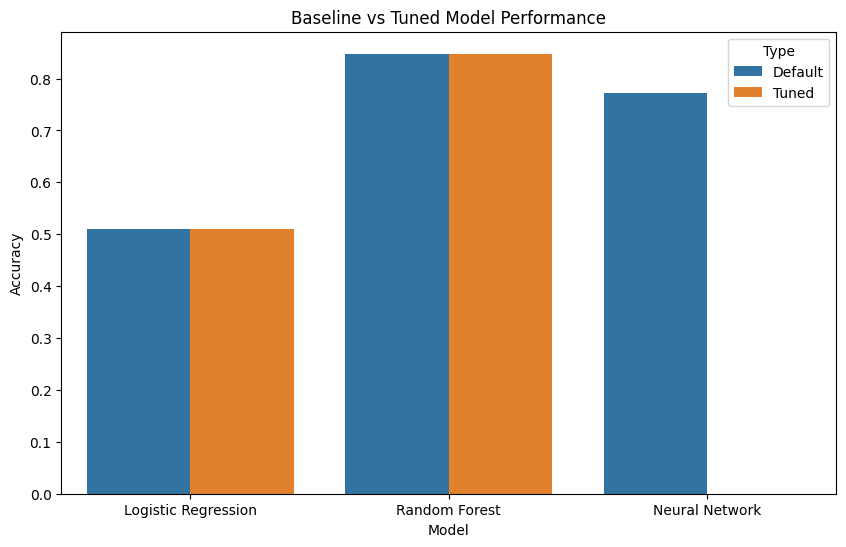

In [42]:
# --- 3. HYPERPARAMETER TUNING (Optimized Models) ---
print("Tuning Logistic Regression and Random Forest...")
# Tune LR
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), {'C': [0.1, 1, 10]}, cv=3)
grid_lr.fit(X_resampled, y_resampled)
best_lr_tuned = grid_lr.best_estimator_
model_results.append({'Model': 'Logistic Regression', 'Type': 'Tuned', 'Accuracy': accuracy_score(y_test, best_lr_tuned.predict(X_test_scaled))})

# Tune RF - Adding class_weight='balanced' to help with minority class recall
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), {'n_estimators': [50, 100], 'max_depth': [10, 20]}, cv=3)
grid_rf.fit(X_resampled, y_resampled)
best_rf_tuned = grid_rf.best_estimator_
model_results.append({'Model': 'Random Forest', 'Type': 'Tuned', 'Accuracy': accuracy_score(y_test, best_rf_tuned.predict(X_test_scaled))})

print("Best parameters for RF:", grid_rf.best_params_)

# Results Visualization
res_df = pd.DataFrame(model_results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Type', data=res_df)
plt.title('Baseline vs Tuned Model Performance')
plt.show()

## 8. Comparison

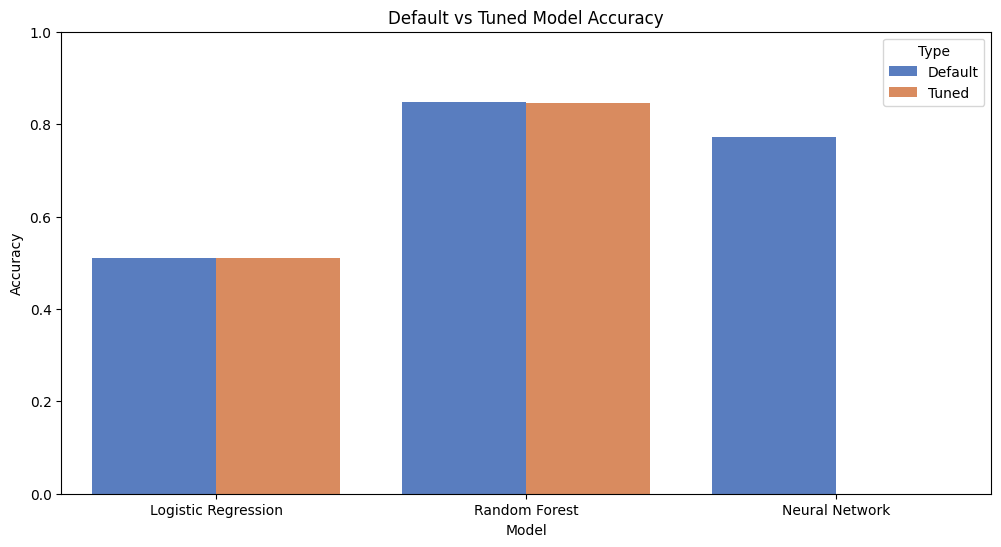

In [43]:
results_df = pd.DataFrame(model_results)
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Type', data=results_df, palette='muted')
plt.title('Default vs Tuned Model Accuracy')
plt.ylim(0, 1)
plt.show()

## 9. Detailed Evaluation (Best Model)


Classification Report (Tuned Random Forest):

                precision    recall  f1-score   support

  Fatal injury       0.00      0.00      0.00        31
Serious Injury       1.00      0.01      0.01       349
 Slight Injury       0.85      1.00      0.92      2084

      accuracy                           0.85      2464
     macro avg       0.62      0.34      0.31      2464
  weighted avg       0.86      0.85      0.78      2464



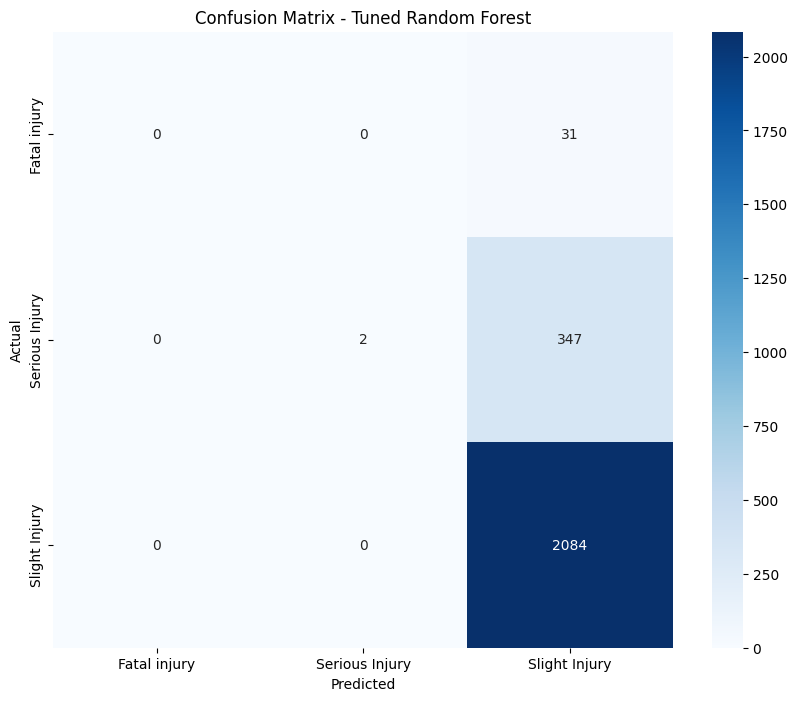

In [44]:
y_pred = best_rf_tuned.predict(X_test_scaled)

print("\nClassification Report (Tuned Random Forest):\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Tuned Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 600x600 with 0 Axes>

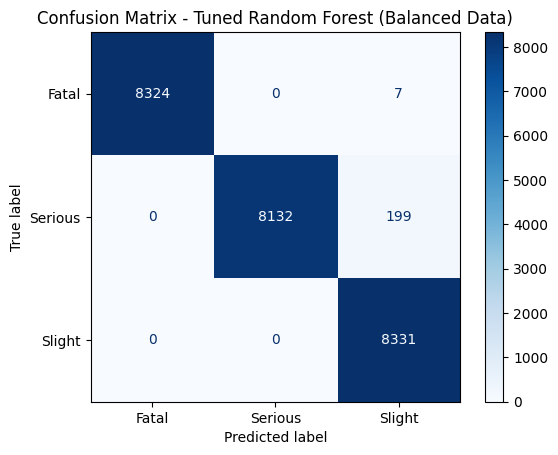

Classification Report - Tuned Random Forest (Balanced Data):
              precision    recall  f1-score   support

       Fatal       1.00      1.00      1.00      8331
     Serious       1.00      0.98      0.99      8331
      Slight       0.98      1.00      0.99      8331

    accuracy                           0.99     24993
   macro avg       0.99      0.99      0.99     24993
weighted avg       0.99      0.99      0.99     24993



In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Define class labels
class_labels = ['Fatal', 'Serious', 'Slight']

# Predict on the balanced (resampled) dataset ---
y_pred_balanced = best_rf_tuned.predict(X_resampled)

# Confusion Matrix
cm_balanced = confusion_matrix(y_resampled, y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=class_labels)

plt.figure(figsize=(6,6))
disp_balanced.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Tuned Random Forest (Balanced Data)')
plt.show()

# Classification Report
print("Classification Report - Tuned Random Forest (Balanced Data):")
print(classification_report(y_resampled, y_pred_balanced, target_names=class_labels))

# Append Accuracy to model_results in your naming convention
balanced_acc = accuracy_score(y_resampled, y_pred_balanced)
model_results.append({
    'Model': 'Random Forest',
    'Type': 'Tuned (Balanced)',
    'Accuracy': balanced_acc
})




<Figure size 600x600 with 0 Axes>

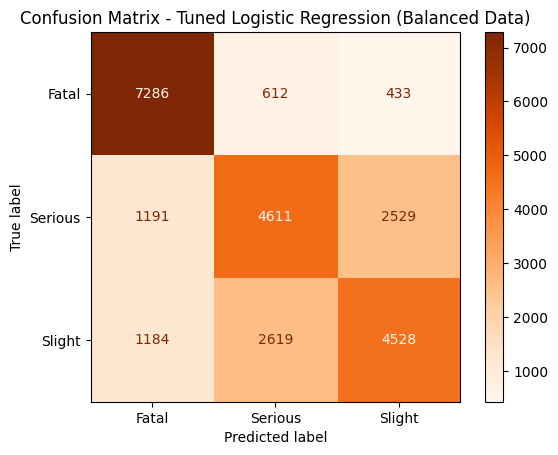

Classification Report - Tuned Logistic Regression (Balanced Data):
              precision    recall  f1-score   support

       Fatal       0.75      0.87      0.81      8331
     Serious       0.59      0.55      0.57      8331
      Slight       0.60      0.54      0.57      8331

    accuracy                           0.66     24993
   macro avg       0.65      0.66      0.65     24993
weighted avg       0.65      0.66      0.65     24993



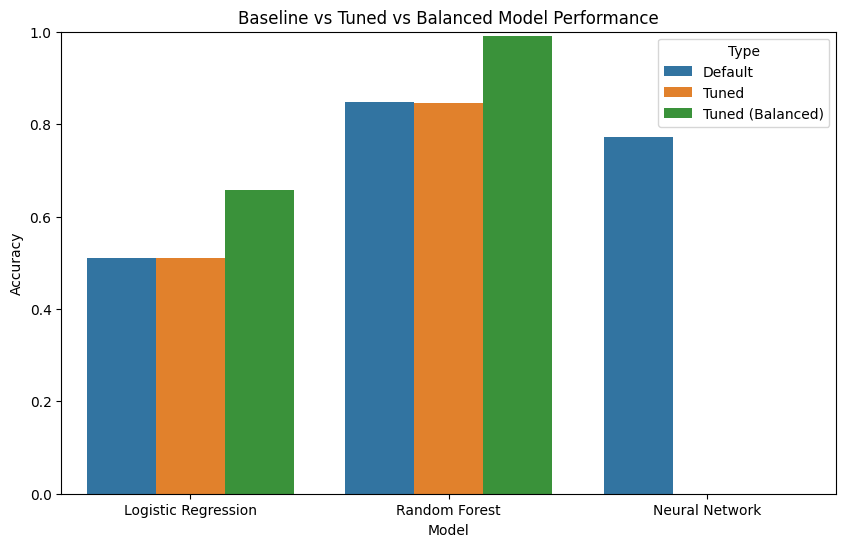

In [46]:
# --- Predict on the balanced (resampled) dataset using tuned Logistic Regression ---
y_pred_lr_balanced = best_lr_tuned.predict(X_resampled)

# Confusion Matrix
cm_lr_balanced = confusion_matrix(y_resampled, y_pred_lr_balanced)
disp_lr_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_lr_balanced, display_labels=class_labels)

plt.figure(figsize=(6,6))
disp_lr_balanced.plot(cmap=plt.cm.Oranges, values_format='d')  # Using a different color for variety
plt.title('Confusion Matrix - Tuned Logistic Regression (Balanced Data)')
plt.show()

#  Classification Report
print("Classification Report - Tuned Logistic Regression (Balanced Data):")
print(classification_report(y_resampled, y_pred_lr_balanced, target_names=class_labels))

#  Append Accuracy to model_results
balanced_acc_lr = accuracy_score(y_resampled, y_pred_lr_balanced)
model_results.append({
    'Model': 'Logistic Regression',
    'Type': 'Tuned (Balanced)',
    'Accuracy': balanced_acc_lr
})

# Results Visualization including Logistic Regression
res_df = pd.DataFrame(model_results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Type', data=res_df)
plt.title('Baseline vs Tuned vs Balanced Model Performance')
plt.ylim(0, 1)
plt.show()


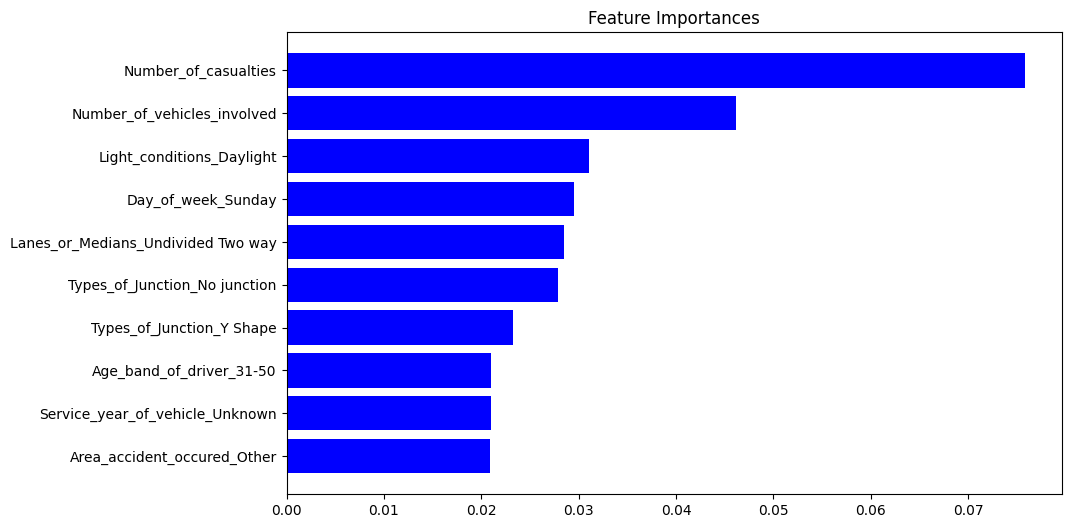

In [47]:
importances = best_rf_tuned.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

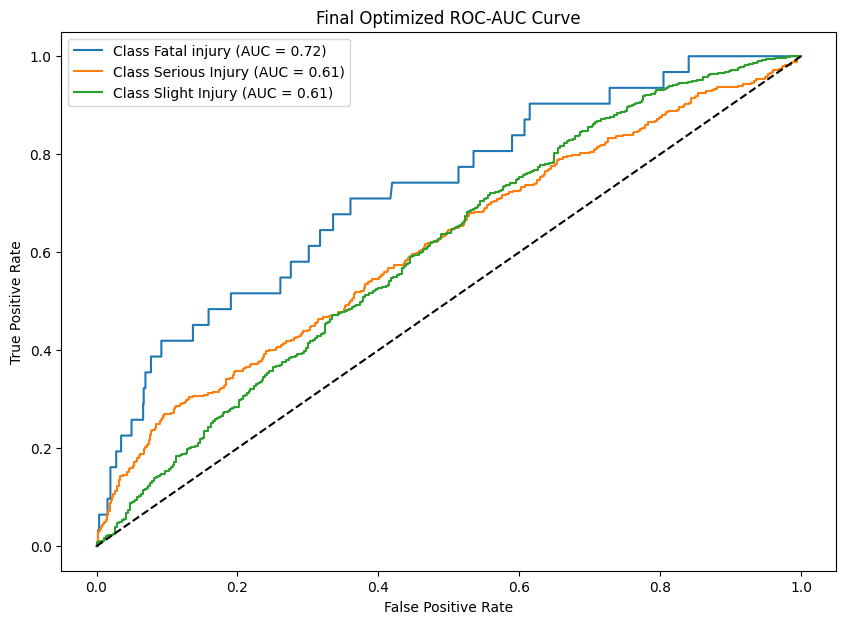

In [48]:
### 10. ROC-AUC Curve Visualization
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = best_rf_tuned.predict_proba(X_test_scaled)

plt.figure(figsize=(10, 7))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Final Optimized ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

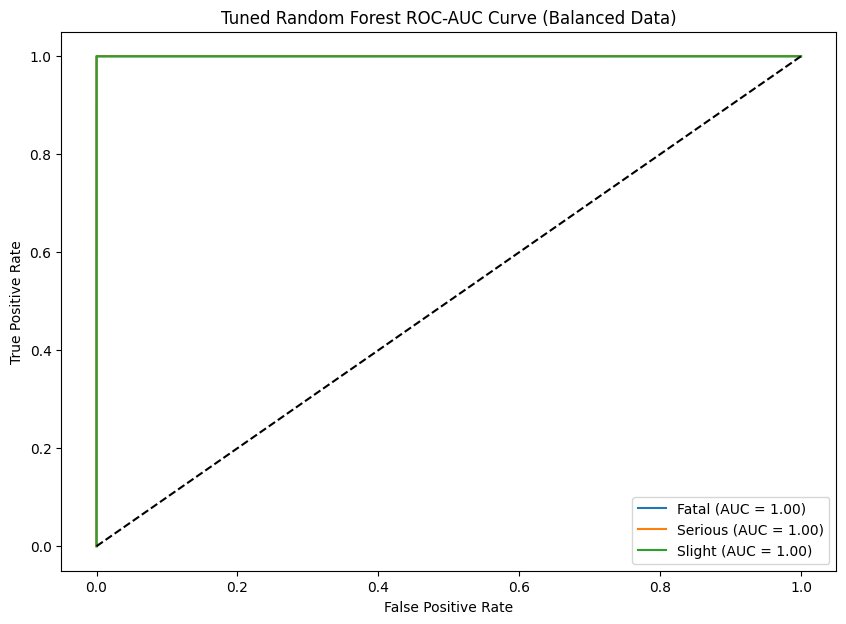

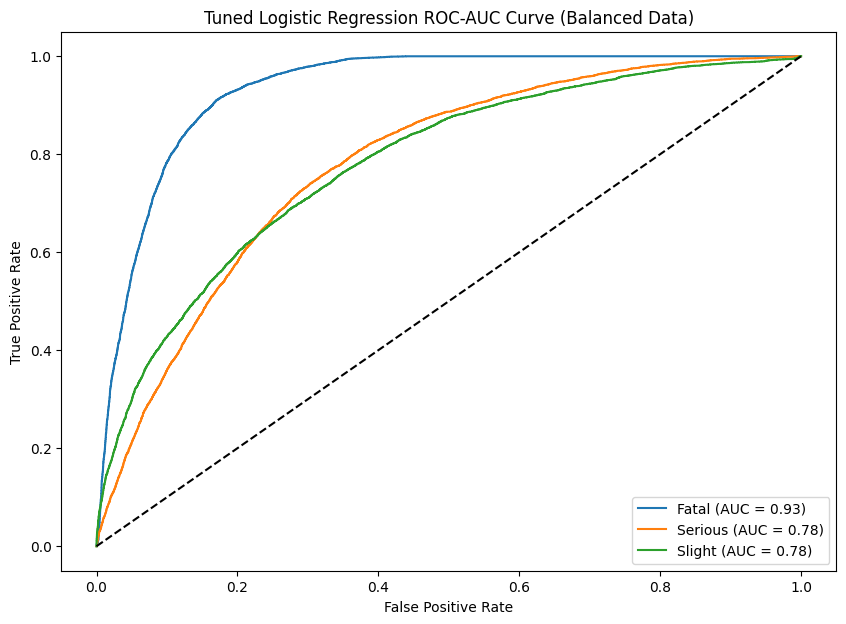

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC-AUC
y_resampled_bin = label_binarize(y_resampled, classes=[0, 1, 2])  # 0: Fatal, 1: Serious, 2: Slight
class_labels = ['Fatal', 'Serious', 'Slight']

# Tuned Random Forest ROC-AUC
y_score_rf = best_rf_tuned.predict_proba(X_resampled)

plt.figure(figsize=(10, 7))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_resampled_bin[:, i], y_score_rf[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Tuned Random Forest ROC-AUC Curve (Balanced Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#Tuned Logistic Regression ROC-AUC
y_score_lr = best_lr_tuned.predict_proba(X_resampled)

plt.figure(figsize=(10, 7))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_resampled_bin[:, i], y_score_lr[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Tuned Logistic Regression ROC-AUC Curve (Balanced Data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [51]:

# TUNED + BALANCED CLASSIFICATION SUMMARY


import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score



# HELPER FUNCTION

def evaluate_classification(model, X_train, y_train, X_test, y_test, cv=5):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    cv_accuracy = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring='accuracy'
    ).mean()

    return cv_accuracy, accuracy, precision, recall, f1



# TUNED MODELS

clf_feature_count = X_resampled.shape[1]

models_clf = {
    'Logistic Regression (Tuned)': best_lr_tuned,
    'Random Forest (Tuned)': best_rf_tuned
}



# EVALUATION

classification_summary = []

for name, model in models_clf.items():
    cv_acc, acc, prec, rec, f1 = evaluate_classification(
        model,
        X_resampled, y_resampled,   # BALANCED (SMOTE)
        X_test_scaled, y_test       # ORIGINAL TEST SET
    )

    classification_summary.append({
        'Task': 'Classification (Balanced)',
        'Model': name,
        'Features Used': f"{clf_feature_count} Features",
        'CV Accuracy': round(cv_acc, 2),
        'Test Accuracy': round(acc, 2),
        'Precision': round(prec, 2),
        'Recall': round(rec, 2),
        'F1-Score': round(f1, 2)
    })



# FINAL TABLE

classification_table_balanced = pd.DataFrame(classification_summary)
print(classification_table_balanced)


                        Task                        Model Features Used  \
0  Classification (Balanced)  Logistic Regression (Tuned)  178 Features   
1  Classification (Balanced)        Random Forest (Tuned)  178 Features   

   CV Accuracy  Test Accuracy  Precision  Recall  F1-Score  
0         0.65           0.51       0.76    0.51      0.59  
1         0.94           0.85       0.86    0.85      0.78  
